In [2]:
import torch 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
from torch.distributions import MultivariateNormal

plt.style.use("dark_background")
sys.path.append("..\\")
plt.style.use("dark_background")
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_prior = torch.load("../weights_1000ep.pt")
from model import ScoreNetwork0
score_prior = ScoreNetwork0().to(device)
score_prior.load_state_dict(weights_prior)

<All keys matched successfully>

### Just to keep my mind clear: 
Our observation is the sampled visibility with some noise, so:
$$
\mathbf{y} = S(u,v)V(u,v) + \boldsymbol{\eta}
$$

To start, we just take the noise to be an isotropic gaussian so: $\eta \sim \mathcal{N}(0, \sigma^2 I)$ and we choose quite small (a lot of information is already lost due sampling of the visibility). 

Considering that our model is linear for our inference problem, we have that: 
$$
\mathbf{y} = A\mathbf{x} + \boldsymbol{\eta}
$$
where $\mathbf{x}$ is the true sky brightness and $A = S(u,v)\mathcal{F}(\mathbf{x})$ 

**Important: $\boldsymbol{\eta}$ is complex !**
Since we sample from a gaussian, we can just sample the real part of eta and the imaginary part

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                   28                                                  NAXIS2  =                   28                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   2.363824596008E-05                                                  BMIN    =   1.588911645942E-05                                                  BPA     =   5.916237258911E+01          

Text(0.5, 1.0, 'Dirty image with noise')

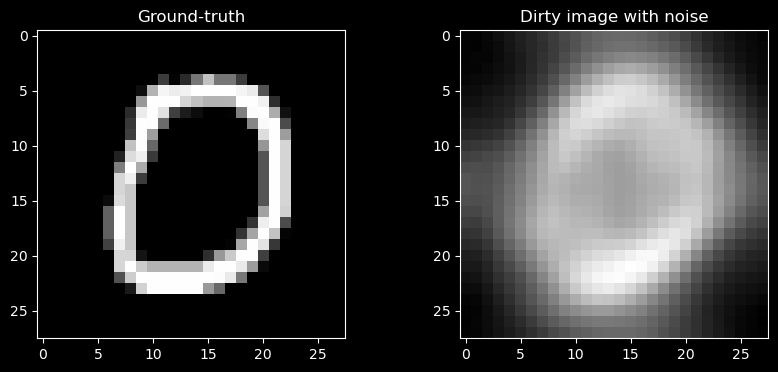

In [121]:
# Path to your .fits file
fits_file_path = '../psf_28.fits'

# Open the .fits file using Astropy
with fits.open(fits_file_path) as hdul:
    # Get the header and data from the primary HDU (Extension 0)
    header = hdul[0].header
    psf = torch.tensor((hdul[0].data).astype(np.float32))[0,0, ...].to(device)

# Now you can work with the header and data as needed
# For example, you can print the header and check the data shape:
print(header)
print(psf.shape)
dataset = torch.load("../../MNIST_torch/test_images.pt")
k = np.random.randint(len(dataset))
k = 10

img_size = 28
x = dataset[k].reshape(img_size, img_size).to(device)

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

vis_full = ft(x).flatten()
sampling_function= ft(torch.fft.ifftshift(psf/torch.sum(psf))).flatten()
vis_sampled = sampling_function * vis_full

sigma_likelihood = 1e-5
vis_sampled = vis_sampled.flatten()
vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])

y_dim = len(vis_sampled)  
dist_likelihood = MultivariateNormal(loc = torch.zeros(y_dim).to(device), covariance_matrix=sigma_likelihood **2 * torch.eye(y_dim).to(device))
eta = dist_likelihood.sample([])

y = vis_sampled + eta 



# PLOTS##################
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
dirty_image_noise = ift((y[:img_size**2] + 1j * y[img_size**2:]).reshape(img_size, img_size)).real


axs[0].imshow(x.reshape(img_size, img_size).cpu(), cmap = "gray")
axs[0].set_title("Ground-truth")
axs[1].imshow(dirty_image_noise.cpu(), cmap = "gray")
axs[1].set_title("Dirty image with noise")


In [122]:

def beta(t): 
    return 0.1 + (20-0.1) * t
def int_beta(t): 
    return 0.1 * t + (20 - 0.1) * t **2 / 2
 
def sigma(t): 
    return torch.sqrt(1-torch.exp(-int_beta(t)))

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(y_dim, device = y.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)

def f(x): 
    vis_full = ft(x.reshape(img_size, img_size)).flatten()
    vis_sampled = sampling_function * vis_full

    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: logprob_likelihood(y- f(x),  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(y_dim, device = x.device))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_prior(x, t) + score_likelihood(x, t)

x = torch.randn([10, img_size ** 2]).to(device) 
t = torch.ones(size = [10, 1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_likelihood(x, t))
#logprob_likelihood(y-f2(x), sigma_likelihood**2 * torch.eye(y_dim, device = x.device)).shape

tensor(0.0160, device='cuda:0')
tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        ...,
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')


In [123]:

def f2(x): 
    vis_full = ft(x.reshape(-1, img_size, img_size)).flatten(1)
    vis_sampled = sampling_function * vis_full

    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag], dim = -1)
    return vis_sampled

In [124]:
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x)
            x_mean  = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt 
            noise = (beta(t) * -dt) ** 0.5 * z 
            x = x_mean + noise
            t += dt
    return x_mean

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    X = torch.empty([num_steps, num_samples, img_size**2])
    grads = []
    logprobs = []
    with torch.no_grad(): 
        for i in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            x_mean = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt
            noise = (beta(t) * -dt) ** 0.5 * z
 
            grads.append(torch.sum(score_likelihood(x, t).flatten(1)**2, axis = 1).mean().cpu())
            
            #logprobs.append(logprob_likelihood(y- f2(x),  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(y_dim, device = x.device)))

            x = x_mean + noise
            t += dt

            X[i, :, :] = x_mean
            

    return x_mean, X, grads, logprobs


#pc_samples = pc_sampler(num_samples = 100, num_pred_steps = 500, num_corr_steps = 20, snr = 1e-2, score_function = score_posterior, img_size = 28)
euler_samples, mean, grads, logprobs = euler_sampler(num_samples = 64, num_steps = 500, score_function = score_posterior, img_size = 28)


100%|██████████| 499/499 [04:34<00:00,  1.82it/s]


In [106]:
logprob_likelihood(y - f2(euler_samples), (sigma_likelihood ** 2) * torch.eye(y_dim, device = y.device)).mean()

tensor(-15941123., device='cuda:0')

In [82]:
print(f"{logprob_likelihood(y - f2(euler_samples), (sigma_likelihood ** 2) * torch.eye(y_dim, device = y.device)).mean().item():.1g}")

-1e+07


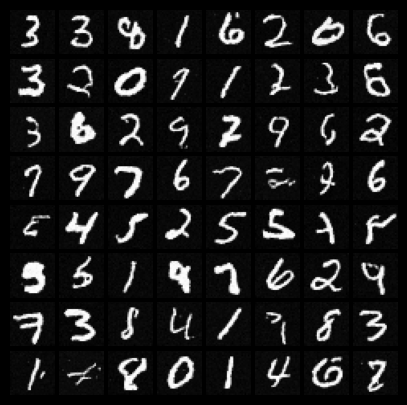

In [125]:
def plot_samples(samples, nrows, ncols): 
    plt.style.use("dark_background")
    if samples.shape[0]< nrows * ncols: 
        raise ValueError("Not enough samples for the number of rows and cols specified")
    fig, axs = plt.subplots(nrows, ncols, figsize=(5, 5))
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            axs[i, j].imshow(samples[k].reshape(28, 28).detach().cpu().numpy(), cmap="gray")
            axs[i, j].axis("off")
            k+=1
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    

plot_samples(euler_samples, nrows = 8, ncols = 8)

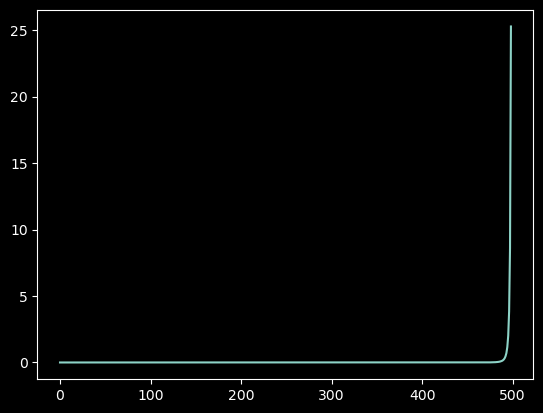

In [96]:
plt.plot(grads)

In [93]:
epochs = [400, 480, 485, 490]
X = [mean[400, :5, :], mean[480, :5], mean[485, :5], mean[490, :5]]

In [39]:
mean[400,:5, :].shape

torch.Size([5, 784])

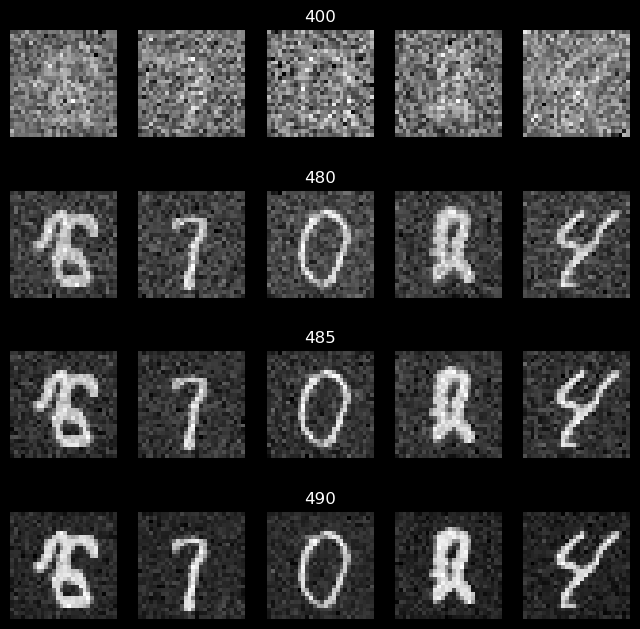

In [94]:
n_cols = 5
n_rows = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize =(8, 8))

for i in range(n_rows): 
    for j in range(n_cols): 
        axs[i, j].imshow(X[i][j].reshape(img_size, img_size).cpu(), cmap = "gray")
        axs[i, j].axis("off")
        axs[i, 2].set_title(f"{epochs[i]}")

In [148]:
euler_samples.min()

tensor(-0.0718, device='cuda:0')